In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
from bs4 import BeautifulSoup
from PIL import Image
from colormap import rgb2hex
import cv2
from scipy import cluster
from sklearn.preprocessing import MinMaxScaler
import imagesize
import random
from sklearn.preprocessing import LabelEncoder
from ipywidgets import interact
import time
from io import BytesIO


# Webscraping - Asos

In [6]:
url = 'https://www.asos.com/adidas-originals/adidas-originals-adicolor-70s-unisex-sweatshirt-in-off-white/prd/202828941?clr=white&colourWayId=202828948&cid=5668'
headers = {'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8','User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15'} # change headers to make it look as if human is accessing webpage, rather than python web scraper
response = requests.get(url, headers = headers)
soup = BeautifulSoup(response.content, "html.parser")



In [7]:
name = soup.select('h1.jcdpl')[0].string

In [8]:
name

"adidas Originals 'adicolor 70s' unisex sweatshirt in off white"

# API - Asos

In [9]:
import requests

url = "https://asos2.p.rapidapi.com/categories/list"

querystring = {"country":"US","lang":"en-US"}

headers = {"X-RapidAPI-Key": "e6d0546079msh1698fc71e2b4d4ep1e1163jsnecaf48e249c5",
"X-RapidAPI-Host": "asos2.p.rapidapi.com"}

response = requests.request("GET", url, headers=headers, params=querystring).json()

In [10]:
brands = np.array(response['brands'][0:4])

In [11]:
cats = np.array([cat['link']['categoryId'] for brand in brands for cat in brand['children']])

In [12]:
cats_sample = np.random.choice(cats,10)

In [13]:
cats_sample

array([50496, 27580,  8891, 27884, 29297, 25579,  7610, 21310, 19978,
       19989])

In [14]:
url = "https://asos2.p.rapidapi.com/products/v2/list"

products = []

for cat in cats_sample:
    querystring = {f"store":"US","offset":"0","categoryId":{cat},"limit":"48","sort":"freshness","lang":"en-UK"}
    response = requests.request("GET", url, headers=headers, params=querystring).json()
    products.append(response)


In [15]:
products = np.array(products)

In [16]:
product_info = np.array([{'id':product['id'],'name':product['name'],'price_current':product['price']['current']['value'],'price_previous':product['price']['previous']['value'],'marked_down':product['price']['isMarkedDown'],'outlet':product['price']['isOutletPrice'],'selling_fast':product['isSellingFast'],'brand':product['brandName'], 'url':'https://www.asos.com/us/'+product['url'], 'url_image': [product['imageUrl']]+[product['imageUrl'][:product['imageUrl'].index(f"{product['id']}-")]+f"{product['id']}-{num}" for num in range(2,5)]} for cat in products for product in cat['products']])
                         
                   

In [17]:
product_info

array([{'id': 202719737, 'name': 'Gbemi joey tie front crop top in postcard print - part of a set', 'price_current': 130.0, 'price_previous': None, 'marked_down': False, 'outlet': False, 'selling_fast': False, 'brand': 'Gbemi', 'url': 'https://www.asos.com/us/gbemi/gbemi-joey-tie-front-crop-top-in-postcard-print-part-of-a-set/prd/202719737?clr=multi&colourWayId=202719739', 'url_image': ['images.asos-media.com/products/gbemi-joey-tie-front-crop-top-in-postcard-print-part-of-a-set/202719737-1-multi', 'images.asos-media.com/products/gbemi-joey-tie-front-crop-top-in-postcard-print-part-of-a-set/202719737-2', 'images.asos-media.com/products/gbemi-joey-tie-front-crop-top-in-postcard-print-part-of-a-set/202719737-3', 'images.asos-media.com/products/gbemi-joey-tie-front-crop-top-in-postcard-print-part-of-a-set/202719737-4']},
       {'id': 202719776, 'name': 'Gbemi tolu cropped shirt in logo print - part of a set', 'price_current': 122.0, 'price_previous': None, 'marked_down': False, 'outlet':

# DeepFashion attribute classification

In [414]:
cat_names = pd.read_csv('Data/DeepFashion_attributes - train/list_category.txt',sep ='\s+',header=None).reset_index().rename(columns={0:'category',1:'category_type','index':'cat_num'})



In [415]:
cat_names['cat_num'] = cat_names['cat_num'].apply(lambda x : x+1)

In [416]:
cat_names.head()

cat_num     category  category_type
0        1       Anorak              1
1        2       Blazer              1
2        3       Blouse              1
3        4       Bomber              1
4        5  Button-Down              1

In [417]:
cat_num = pd.read_csv('Data/DeepFashion_attributes - train/cat.txt',sep='\s+',header=None,names=['category']).reset_index().rename(columns={'category':'cat_num','index':'img'})



In [418]:
cat_num[['img']] = cat_num[['img']].applymap(lambda x: x[4:])

In [419]:
cat_num.head()

img  cat_num
0  Sheer_Pleated-Front_Blouse/img_00000001.jpg        3
1  Sheer_Pleated-Front_Blouse/img_00000002.jpg        3
2  Sheer_Pleated-Front_Blouse/img_00000003.jpg        3
3  Sheer_Pleated-Front_Blouse/img_00000004.jpg        3
4  Sheer_Pleated-Front_Blouse/img_00000005.jpg        3

In [420]:
cat_num['shape_low'] = cat_num.iloc[:,0].apply(lambda row: imagesize.get('data/DeepFashion_categorical_images_low/'+row)[0])
cat_num['shape_high'] = cat_num.iloc[:,0].apply(lambda row: imagesize.get('data/DeepFashion_categorical_images_high/'+row)[0])



In [421]:
cat_num

img  cat_num  shape_low  \
0         Sheer_Pleated-Front_Blouse/img_00000001.jpg        3        300   
1         Sheer_Pleated-Front_Blouse/img_00000002.jpg        3        205   
2         Sheer_Pleated-Front_Blouse/img_00000003.jpg        3        207   
3         Sheer_Pleated-Front_Blouse/img_00000004.jpg        3        200   
4         Sheer_Pleated-Front_Blouse/img_00000005.jpg        3        200   
...                                               ...      ...        ...   
289217  Paisley_Print_Babydoll_Dress/img_00000050.jpg       41        300   
289218  Paisley_Print_Babydoll_Dress/img_00000051.jpg       41        225   
289219  Paisley_Print_Babydoll_Dress/img_00000052.jpg       41        180   
289220  Paisley_Print_Babydoll_Dress/img_00000053.jpg       41        300   
289221  Paisley_Print_Babydoll_Dress/img_00000054.jpg       41        238   

        shape_high  
0              300  
1              736  
2              546  
3              200  
4              682  
...            ...  
289217         354  
289218         560  
289219         180  
289220         300  
289221         300  

[289222 rows x 4 columns]

In [422]:
cat_num['scale'] = cat_num['shape_high']/cat_num['shape_low']


In [423]:
cat_num.drop(columns=['shape_low','shape_high'],inplace=True)

In [424]:
cat_num

img  cat_num     scale
0         Sheer_Pleated-Front_Blouse/img_00000001.jpg        3  1.000000
1         Sheer_Pleated-Front_Blouse/img_00000002.jpg        3  3.590244
2         Sheer_Pleated-Front_Blouse/img_00000003.jpg        3  2.637681
3         Sheer_Pleated-Front_Blouse/img_00000004.jpg        3  1.000000
4         Sheer_Pleated-Front_Blouse/img_00000005.jpg        3  3.410000
...                                               ...      ...       ...
289217  Paisley_Print_Babydoll_Dress/img_00000050.jpg       41  1.180000
289218  Paisley_Print_Babydoll_Dress/img_00000051.jpg       41  2.488889
289219  Paisley_Print_Babydoll_Dress/img_00000052.jpg       41  1.000000
289220  Paisley_Print_Babydoll_Dress/img_00000053.jpg       41  1.000000
289221  Paisley_Print_Babydoll_Dress/img_00000054.jpg       41  1.260504

[289222 rows x 3 columns]

In [425]:
cat = cat_num.merge(cat_names, on='cat_num', how='left').drop(columns='cat_num').set_index('img')



In [426]:
cat

scale category  \
img                                                                
Sheer_Pleated-Front_Blouse/img_00000001.jpg    1.000000   Blouse   
Sheer_Pleated-Front_Blouse/img_00000002.jpg    3.590244   Blouse   
Sheer_Pleated-Front_Blouse/img_00000003.jpg    2.637681   Blouse   
Sheer_Pleated-Front_Blouse/img_00000004.jpg    1.000000   Blouse   
Sheer_Pleated-Front_Blouse/img_00000005.jpg    3.410000   Blouse   
...                                                 ...      ...   
Paisley_Print_Babydoll_Dress/img_00000050.jpg  1.180000    Dress   
Paisley_Print_Babydoll_Dress/img_00000051.jpg  2.488889    Dress   
Paisley_Print_Babydoll_Dress/img_00000052.jpg  1.000000    Dress   
Paisley_Print_Babydoll_Dress/img_00000053.jpg  1.000000    Dress   
Paisley_Print_Babydoll_Dress/img_00000054.jpg  1.260504    Dress   

                                               category_type  
img                                                           
Sheer_Pleated-Front_Blouse/img_00000001.jpg                1  
Sheer_Pleated-Front_Blouse/img_00000002.jpg                1  
Sheer_Pleated-Front_Blouse/img_00000003.jpg                1  
Sheer_Pleated-Front_Blouse/img_00000004.jpg                1  
Sheer_Pleated-Front_Blouse/img_00000005.jpg                1  
...                                                      ...  
Paisley_Print_Babydoll_Dress/img_00000050.jpg              3  
Paisley_Print_Babydoll_Dress/img_00000051.jpg              3  
Paisley_Print_Babydoll_Dress/img_00000052.jpg              3  
Paisley_Print_Babydoll_Dress/img_00000053.jpg              3  
Paisley_Print_Babydoll_Dress/img_00000054.jpg              3  

[289222 rows x 3 columns]

In [427]:
cat['category_type'] = cat['category_type'].map({1:'upper',2:'lower',3:'full body'})

In [428]:
attr_names = pd.read_csv('Data/DeepFashion_attributes - train/list_attr.txt',sep='\s+', header=None).rename(columns={0:'attribute',1:'attribute type'})


In [429]:
attr_names

attribute  attribute type
0                    a-line               3
1                  abstract               1
2          abstract_chevron               1
3    abstract_chevron_print               1
4          abstract_diamond               1
..                      ...             ...
995              zip-pocket               4
996                  zip-up               4
997                  zipped               4
998                  zipper               4
999                zippered               4

[1000 rows x 2 columns]

In [430]:
attr_names['attribute type'] = attr_names['attribute type'].map({1:'design',2:'fabric',3:'shape',4:'part',5:'style'})


In [431]:
attr_names

attribute attribute type
0                    a-line          shape
1                  abstract         design
2          abstract_chevron         design
3    abstract_chevron_print         design
4          abstract_diamond         design
..                      ...            ...
995              zip-pocket           part
996                  zip-up           part
997                  zipped           part
998                  zipper           part
999                zippered           part

[1000 rows x 2 columns]

In [432]:
attr_names_headers = attr_names.iloc[:,0]
attr_names_headers

0                      a-line
1                    abstract
2            abstract_chevron
3      abstract_chevron_print
4            abstract_diamond
                ...          
995                zip-pocket
996                    zip-up
997                    zipped
998                    zipper
999                  zippered
Name: attribute, Length: 1000, dtype: object

In [433]:
attr = pd.read_csv('Data/DeepFashion_attributes - train/attr.txt',sep='\s+',header=None, names=attr_names_headers).reset_index()


In [434]:
attr['index'] = attr['index'].apply(lambda x: x[4:])

In [435]:
attr.set_index('index',inplace=True)

In [436]:
attr

a-line  abstract  \
index                                                             
Sheer_Pleated-Front_Blouse/img_00000001.jpg        -1        -1   
Sheer_Pleated-Front_Blouse/img_00000002.jpg        -1        -1   
Sheer_Pleated-Front_Blouse/img_00000003.jpg        -1        -1   
Sheer_Pleated-Front_Blouse/img_00000004.jpg        -1        -1   
Sheer_Pleated-Front_Blouse/img_00000005.jpg        -1        -1   
...                                               ...       ...   
Paisley_Print_Babydoll_Dress/img_00000050.jpg      -1        -1   
Paisley_Print_Babydoll_Dress/img_00000051.jpg      -1        -1   
Paisley_Print_Babydoll_Dress/img_00000052.jpg      -1        -1   
Paisley_Print_Babydoll_Dress/img_00000053.jpg      -1        -1   
Paisley_Print_Babydoll_Dress/img_00000054.jpg      -1        -1   

                                               abstract_chevron  \
index                                                             
Sheer_Pleated-Front_Blouse/img_00000001.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000002.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000003.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000004.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000005.jpg                  -1   
...                                                         ...   
Paisley_Print_Babydoll_Dress/img_00000050.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000051.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000052.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000053.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000054.jpg                -1   

                                               abstract_chevron_print  \
index                                                                   
Sheer_Pleated-Front_Blouse/img_00000001.jpg                        -1   
Sheer_Pleated-Front_Blouse/img_00000002.jpg                        -1   
Sheer_Pleated-Front_Blouse/img_00000003.jpg                        -1   
Sheer_Pleated-Front_Blouse/img_00000004.jpg                        -1   
Sheer_Pleated-Front_Blouse/img_00000005.jpg                        -1   
...                                                               ...   
Paisley_Print_Babydoll_Dress/img_00000050.jpg                      -1   
Paisley_Print_Babydoll_Dress/img_00000051.jpg                      -1   
Paisley_Print_Babydoll_Dress/img_00000052.jpg                      -1   
Paisley_Print_Babydoll_Dress/img_00000053.jpg                      -1   
Paisley_Print_Babydoll_Dress/img_00000054.jpg                      -1   

                                               abstract_diamond  \
index                                                             
Sheer_Pleated-Front_Blouse/img_00000001.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000002.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000003.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000004.jpg                  -1   
Sheer_Pleated-Front_Blouse/img_00000005.jpg                  -1   
...                                                         ...   
Paisley_Print_Babydoll_Dress/img_00000050.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000051.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000052.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000053.jpg                -1   
Paisley_Print_Babydoll_Dress/img_00000054.jpg                -1   

                                               abstract_floral  \
index                                                            
Sheer_Pleated-Front_Blouse/img_00000001.jpg                 -1   
Sheer_Pleated-Front_Blouse/img_00000002.jpg                 -1   
Sheer_Pleated-Front_Blouse/img_00000003.jpg                 -1   
Sheer_Pleated-Front_Blouse/img_00000004.jpg                 -1   
Sheer_Pleated-Front_Blouse/img_00000005.jpg                 -1   
...                

In [437]:
bb = pd.read_csv('Data/DeepFashion_attributes - train/bbox.txt',sep='\s+',header=None,index_col=False, names=['img','x_1', 'y_1', 'x_2', 'y_2'])


In [438]:
bb['img'] = bb['img'].apply(lambda x: x[4:])

In [439]:
bb.set_index('img',inplace=True)

In [440]:
bb

x_1  y_1  x_2  y_2
img                                                              
Sheer_Pleated-Front_Blouse/img_00000001.jpg     72   79  232  273
Sheer_Pleated-Front_Blouse/img_00000002.jpg     67   59  155  161
Sheer_Pleated-Front_Blouse/img_00000003.jpg     65   65  156  200
Sheer_Pleated-Front_Blouse/img_00000004.jpg     51   62  167  182
Sheer_Pleated-Front_Blouse/img_00000005.jpg     46   88  166  262
...                                            ...  ...  ...  ...
Paisley_Print_Babydoll_Dress/img_00000050.jpg    1    1  300  300
Paisley_Print_Babydoll_Dress/img_00000051.jpg   14   58  225  277
Paisley_Print_Babydoll_Dress/img_00000052.jpg   18   41  149  230
Paisley_Print_Babydoll_Dress/img_00000053.jpg   75   47  220  300
Paisley_Print_Babydoll_Dress/img_00000054.jpg   36   63  202  296

[289222 rows x 4 columns]

In [441]:
pd.set_option('display.max_columns', None)

In [442]:
landmarks = pd.read_csv('Data/DeepFashion_attributes - train/landmarks.txt',sep='\s+',names=['img','clothes_type','v1','x1','y1','v2','x2','y2','v3','x3','y3','v4','x4','y4','v5','x5','y5','v6','x6','y6','v7','x7','y7','v8','x8','y8']).fillna(0).drop(columns=['clothes_type'])


In [443]:
landmarks['img'] = landmarks['img'].apply(lambda x: x[4:])

In [444]:
landmarks.set_index('img',inplace=True)

In [445]:
data_full = cat.join(attr).join(bb).join(landmarks)



In [446]:
data_full.reset_index(inplace=True)

In [447]:
data_full

img     scale category  \
0         Sheer_Pleated-Front_Blouse/img_00000001.jpg  1.000000   Blouse   
1         Sheer_Pleated-Front_Blouse/img_00000002.jpg  3.590244   Blouse   
2         Sheer_Pleated-Front_Blouse/img_00000003.jpg  2.637681   Blouse   
3         Sheer_Pleated-Front_Blouse/img_00000004.jpg  1.000000   Blouse   
4         Sheer_Pleated-Front_Blouse/img_00000005.jpg  3.410000   Blouse   
...                                               ...       ...      ...   
289217  Paisley_Print_Babydoll_Dress/img_00000050.jpg  1.180000    Dress   
289218  Paisley_Print_Babydoll_Dress/img_00000051.jpg  2.488889    Dress   
289219  Paisley_Print_Babydoll_Dress/img_00000052.jpg  1.000000    Dress   
289220  Paisley_Print_Babydoll_Dress/img_00000053.jpg  1.000000    Dress   
289221  Paisley_Print_Babydoll_Dress/img_00000054.jpg  1.260504    Dress   

       category_type  a-line  abstract  abstract_chevron  \
0              upper      -1        -1                -1   
1              upper      -1        -1                -1   
2              upper      -1        -1                -1   
3              upper      -1        -1                -1   
4              upper      -1        -1                -1   
...              ...     ...       ...               ...   
289217     full body      -1        -1                -1   
289218     full body      -1        -1                -1   
289219     full body      -1        -1                -1   
289220     full body      -1        -1                -1   
289221     full body      -1        -1                -1   

        abstract_chevron_print  abstract_diamond  abstract_floral  \
0                           -1                -1               -1   
1                           -1                -1               -1   
2                           -1                -1               -1   
3                           -1                -1               -1   
4                           -1                -1               -1   
...                        ...               ...              ...   
289217                      -1                -1               -1   
289218                      -1                -1               -1   
289219                      -1                -1               -1   
289220                      -1                -1               -1   
289221                      -1                -1               -1   

        abstract_floral_print  abstract_geo  abstract_geo_print  \
0                          -1            -1                  -1   
1                          -1            -1                  -1   
2                          -1            -1                  -1   
3                          -1            -1                  -1   
4                          -1            -1                  -1   
...                       ...           ...                 ...   
289217                     -1            -1                  -1   
289218                     -1            -1                  -1   
289219                     -1            -1                  -1   
289220                     -1            -1                  -1   
289221                     -1            -1                  -1   

        abstract_paisley  abstract_pattern  abstract_print  abstract_printed  \
0                     -1                -1              -1                -1   
1                     -1                -1              -1                -1   
2                     -1                -1              -1                -1   
3                     -1                -1              -1                -1   
4                     -1                -1              -1                -1   
...                  ...               ...             ...               ...   
289217                -1                -1              -1                -1   
289218                -1                -1              -1                -1   
289219                -1                -1              -1    

In [448]:
def get_img_details(index):
    path = 'data/DeepFashion_categorical_images_high/'
    img_name = data_full.iloc[index,0]
    full_path = path+img_name
    
    image = Image.open(full_path)
    image_width = image.size[0]
    image_height = image.size[1]
    
    
    v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4=data_full.iloc[index,-24:-12]
    lm_x = [x1,x2,x3,x4]
    lm_y = [y1,y2,y3,y4]
    lm_v = [v1,v2,v3,v4]
    
    section = data_full.iloc[index,3]

    if section == 'upper' or section == 'full body':
        v5,x5,y5,v6,x6,y6=data_full.iloc[index,-12:-6]
        lm_x.extend([x5,x6])
        lm_y.extend([y5,y6])
        lm_v.extend([v5,v6])
    if section == 'full body':
        v7,x7,y7,v8,x8,y8=data_full.iloc[index,-6:]
        lm_x.extend([x7,x8])
        lm_y.extend([y7,y8])
        lm_v.extend([v7,v8])
    
    lm_x = np.array(lm_x)
    lm_y = np.array(lm_y)
    lm_x = lm_x[lm_x !=0]
    lm_y = lm_y[lm_y !=0]

    return full_path, lm_x, lm_y

In [449]:
def get_colors(index):
    full_path, lm_x, lm_y = get_img_details(index)
    path = 'data/DeepFashion_categorical_images_low/'
    img_name = data_full.iloc[index,0]
    full_path = path+img_name
    clusters = 4
    sub = 0
    
    img = Image.open(full_path)

    img_processed,img_labelled = process_img(index)
    
    img_ar = np.asarray(img_processed) # convert image to vector array 
    shape = img_ar.shape
    img_ar = img_ar.reshape(-1, shape[2]).astype(float) # reshape image --> 2D vector

    # Kmeans algorithm on 2D vector to form 'num_clusters':
    codebook, dist_mean = cluster.vq.kmeans(img_ar, clusters) 
    # 'codebook' stores rgb value for each cluster
    # 'dist_mean' stores mean euclidian distance between each observation and its closest centroid
        
    # assign code to each observation in image vector 'img_ar' (code value corresponds to the rgb color cluster which is closest to the observation)
    codes, dists = cluster.vq.vq(img_ar, codebook)
    # 'codes' stores code for each observation in 'img_ar' which corresponds to rgb value in 'codebook'
    # 'dists' stores euclidian distance between each observation and its nearest rgb color cluster 

    code_counts = sorted({code: np.sum(codes == code) for code in codes}.items(), key=lambda x:x[1],reverse=True)
    color_counts = {code[1]: codebook[code[0]] for code in code_counts[:4]}
    if (np.mean(list(color_counts.values())[0]) -3) < 5:
        sub = list(color_counts.keys())[0]
        color_counts.pop(list(color_counts.keys())[0])
    elif (np.mean(list(color_counts.values())[1]) -3) < 5:
        sub = list(color_counts.keys())[1]
        color_counts.pop(list(color_counts.keys())[1])

        

    fig = plt.figure(figsize=(30,20))
    gs = fig.add_gridspec(nrows=2, ncols=4) # use gridspec to create more complex grid
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(img)
    ax.title.set_text('Original image')
    
    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(img_labelled)
    ax.title.set_text('Labelled image')
    
    ax = fig.add_subplot(gs[0, 2])
    ax.imshow(img_processed)
    ax.title.set_text('Preprocessed image')
    
    for i,color in enumerate(color_counts.items()):
        rgb = tuple(color[1]/255)
        hex_ = rgb2hex(*color[1].astype('int'))
        perc = round((color[0]/(img_ar.shape[0]-sub)*100),2)
        rectangle = plt.Rectangle((0,0), 100, 100,fc=rgb,fill=True)
        ax = fig.add_subplot(gs[1, i])
        ax.add_patch(rectangle)
        ax.title.set_text(f'Hex: {hex_} | Percentage: {perc}%')
    return



In [450]:
def process_img(index):
    full_path, lm_x, lm_y = get_img_details(index)
    path = 'data/DeepFashion_categorical_images_low/'
    img_name = data_full.iloc[index,0]
    full_path = path+img_name
    
    pts_ordered = []
    
    img = cv2.imread(full_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color scheme of image
    pts = (np.array(list(zip(lm_x,lm_y)))).astype('int')
    pts_scaled = pts - pts.min(axis=0) # pts.min(axis=0) gives min pixel in each column
    
    max_y = np.max(pts_scaled[:,1])
    max_x = np.max(pts_scaled[:,0])
    min_y = np.min(pts_scaled[:,1])
    min_x = np.min(pts_scaled[:,0])
    
    
    bl_i = (np.abs(max_y-pts_scaled[:,1]) + np.abs(pts_scaled[:,0]-min_x)).argmin()
    tl_i = (np.abs(min_y-pts_scaled[:,1]) + np.abs(pts_scaled[:,0]-min_x)).argmin()
    tr_i = (np.abs(min_y-pts_scaled[:,1]) + np.abs(pts_scaled[:,0]-max_x)).argmin()
    br_i = (np.abs(max_y-pts_scaled[:,1]) + np.abs(pts_scaled[:,0]-max_x)).argmin()
    
    bl, tl, tr, br = pts_scaled[bl_i],pts_scaled[tl_i],pts_scaled[tr_i],pts_scaled[br_i]
    pts_ordered = np.array([bl,tl,tr,br])

    pts_ordered = np.array(pts_ordered)

    # Crop the bounding rectangle
    x,y,w,h = cv2.boundingRect(pts)
    cropped = img[y:y+h, x:x+w].copy()
    
    # Make mask
    mask = np.zeros(cropped.shape[:2], np.uint8) # create matrix of zeros with same shape as cropped image
    cv2.drawContours(mask, [pts_ordered], -1, (255, 255, 255), -1, cv2.LINE_AA) # create shape with corners 'pts' on mask image 

    # Bitwise and:
    dst = cv2.bitwise_and(cropped, cropped, mask=mask) # bitwise and the cropped image with the mask to keep only pixels within the mask polygon bounds 

    # Create white background 
    bg = np.ones_like(cropped, np.uint8)*0 # matrix with same shape as cropped image 
    cv2.bitwise_not(bg,bg, mask=mask) # white background where mask isn't
    img_processed = bg+dst 
    
    
    # Add polygon lines to original image:
    img_labelled = cropped.copy()
    cv2.polylines(img_labelled, [pts_ordered],
                      True,(255, 0, 0))
    
    return img_processed,img_labelled



In [451]:
def display_img_details(index):
#     l = []
#     while len(l) <= 4:
#         index=random.randint(0,data_full.shape[0])
#         l = [a for a in np.array(data_full.iloc[index,5:-28][data_full.iloc[index,5:-28]==1].index)]
    full_path, lm_x, lm_y = get_img_details(index)
    image = Image.open(full_path)
    image_width = image.size[0]
    image_height = image.size[1]
    
    cat = f"{data_full.iloc[index,2]} ({data_full[data_full['category']==data_full.iloc[index,2]]['img'].nunique()})"
    section = f"{data_full.iloc[index,3]} ({data_full[data_full['category_type']==data_full.iloc[index,3]]['img'].nunique()})"
    attr = [a for a in np.array(data_full.iloc[index,5:-28][data_full.iloc[index,5:-28]==1].index)]
    box_x1,box_y1,box_x2,box_y2 = (np.array(data_full.iloc[index,-28:-24].values))*data_full.iloc[index,1]
        
    width = box_x2-box_x1
    height = -(box_y1-box_y2) 
    
    fig,ax = plt.subplots(figsize=(20,15))
    
    plt.ylim(image_height,-image_height//2)
    plt.xlim(-125,image_width+125)
    
    attr_named = {}
    for a in attr:
        attr_type = attr_names[attr_names['attribute'] == a]['attribute type'].values[0]
        attr_type_count = data_full[data_full[a]==1]['img'].nunique()
        if attr_type in attr_named:
            attr_named[attr_type] = f'{attr_named[attr_type]}, {a.capitalize()} ({attr_type_count})'
        else:
             attr_named[attr_type] = f'{a.capitalize()} ({attr_type_count})'
    attr_named_str = "\n".join(f'{k.capitalize()}: {v.replace("_"," ")}' for k,v in attr_named.items())
    text = '\n'.join([f'Type: {section.capitalize()}',f'Category: {cat}'])+'\n'+attr_named_str
                     
    plt.plot(lm_x*data_full.iloc[index,1],lm_y*data_full.iloc[index,1],markersize=20,marker="o",c='b',lw=0)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    rectangle = plt.Rectangle((box_x1,box_y1), width, height,ec="red",ls='--',fill=False,lw=3)
    plt.gca().add_patch(rectangle)
    
    plt.imshow(image)
    
    get_colors(index)
    return
    

In [452]:
data_full_altered = data_full.iloc[:,4:-28].applymap(lambda x: 0 if x==-1 else 1)

In [453]:
data_full_altered

a-line  abstract  abstract_chevron  abstract_chevron_print  \
0            0         0                 0                       0   
1            0         0                 0                       0   
2            0         0                 0                       0   
3            0         0                 0                       0   
4            0         0                 0                       0   
...        ...       ...               ...                     ...   
289217       0         0                 0                       0   
289218       0         0                 0                       0   
289219       0         0                 0                       0   
289220       0         0                 0                       0   
289221       0         0                 0                       0   

        abstract_diamond  abstract_floral  abstract_floral_print  \
0                      0                0                      0   
1                      0                0                      0   
2                      0                0                      0   
3                      0                0                      0   
4                      0                0                      0   
...                  ...              ...                    ...   
289217                 0                0                      0   
289218                 0                0                      0   
289219                 0                0                      0   
289220                 0                0                      0   
289221                 0                0                      0   

        abstract_geo  abstract_geo_print  abstract_paisley  abstract_pattern  \
0                  0                   0                 0                 0   
1                  0                   0                 0                 0   
2                  0                   0                 0                 0   
3                  0                   0                 0                 0   
4                  0                   0                 0                 0   
...              ...                 ...               ...               ...   
289217             0                   0                 0                 0   
289218             0                   0                 0                 0   
289219             0                   0                 0                 0   
289220             0                   0                 0                 0   
289221             0                   0                 0                 0   

        abstract_print  abstract_printed  abstract_stripe  acid  acid_wash  \
0                    0                 0                0     0          0   
1                    0                 0                0     0          0   
2                    0                 0                0     0          0   
3                    0                 0                0     0          0   
4                    0                 0                0     0          0   
...                ...               ...              ...   ...        ...   
289217               0                 0                0     0          0   
289218               0                 0                0     0          0   
289219               0                 0                0     0          0   
289220               0                 0                0     0          0   
289221               0                 0                0     0          0   

        americana  angeles  animal  animal_print  ankle  applique  \
0               0        0       0             0      0         0   
1               0        0       0             0      0         0   
2               0        0       0             0      0         0   
3               0        0       0             0      0         0   
4               0        0       0             0      0         0   
...           ...      ...     ...    

In [454]:
attribute_count = data_full_altered.apply(pd.value_counts)

In [455]:
attribute_count

a-line  abstract  abstract_chevron  abstract_chevron_print  \
0  285982    283579            289098                  289166   
1    3240      5643               124                      56   

   abstract_diamond  abstract_floral  abstract_floral_print  abstract_geo  \
0            289169           288788                 289018        288982   
1                53              434                    204           240   

   abstract_geo_print  abstract_paisley  abstract_pattern  abstract_print  \
0              289100            289161            289041          287051   
1                 122                61               181            2171   

   abstract_printed  abstract_stripe    acid  acid_wash  americana  angeles  \
0            289045           289093  287097     287488     289119   288689   
1               177              129    2125       1734        103      533   

   animal  animal_print   ankle  applique  arrow_collar     art  asymmetric  \
0  288073        288550  288122    288970        289055  288731      288389   
1    1149           672    1100       252           167     491         833   

   asymmetrical  asymmetrical_hem  athletic  audrey    babe  babydoll  \
0        288002            289028    288205  288998  289026    287892   
1          1220               194      1017     224     196      1330   

   back_bow  back_cutout  back_knit  back_lace  back_striped  backless  \
0    289167       289070     289147     289065        289148    288089   
1        55          152         75        157            74      1133   

     baja  bandage  bandana  bandana_print  barbie  baroque  baroque_print  \
0  289000   288128   288629         288912  288946   288078         288683   
1     222     1094      593            310     276     1144            539   

   baseball   basic  basquiat  batwing   beach    bead  beaded  \
0    287342  287745    289094   288257  287498  288974  286520   
1      1880    1477       128      965    1724     248    2702   

   beaded_chiffon  beaded_collar  beaded_sheer  beaded_shift  beatles     bed  \
0          289055         289157        289157        289137   289000  289136   
1             167             65            65            85      222      86   

   bejeweled    bell  bell-sleeve   bella  belted  belted_chiffon  \
0     289106  288266       289131  288835  285642          289150   
1        116     956           91     387    3580              72   

   belted_floral  belted_floral_print  belted_lace  belted_maxi  belted_plaid  \
0         289129               289164       289134       289072        289158   
1             93                   58           88          150            64   

   bermuda     bib     big    bike   biker    bird  bird_print    blah  \
0   288735  289022  287987  289066  288601  288621      288915  289166   
1      487     200    1235     156     621     601         307      56   

   bleach  bleached  bleached_denim  blurred  boat_neck  bodycon  \
0  288899    288789          289084   289127     288769   282803   
1     323       433             138       95        453     6419   

   bodycon_midi    boho    bold  botanical  botanical_print     bow  bow-back  \
0        288863  287095  288708     288932           289131  287553    289163   
1           359    2127     514        290               91    1669        59   

   bow-front     box  box_pleat  box-pleated    boxy  boxy_crop  boxy_knit  \
0     289160  288517     288897       289165  285506     289036     289147   
1         62     705        325           57    3716        186         75   

   boxy_lace  boxy_pocket  boxy_striped  boyfriend  braided  breton  \
0     289170       289137        289124     287221   288814  289062   
1         52           85            98       2001      408     160   

   breton_stripe  brocade  brooklyn  brooklyn_nets  brushstroke  \
0         289131   288877    288643         288864       289060   
1             91      345       579    

In [456]:
drop = ['abstract','americana','angeles']

In [457]:
combine = [('abstract_chevron_print','abstract_chevron','abstract_diamond'),('abstract_floral','abstract_floral_print'),('abstract_geo','abstract_geo_print')]



In [458]:
columns = list(attribute_count.columns)

In [459]:
attr = 'abstract_pattern'

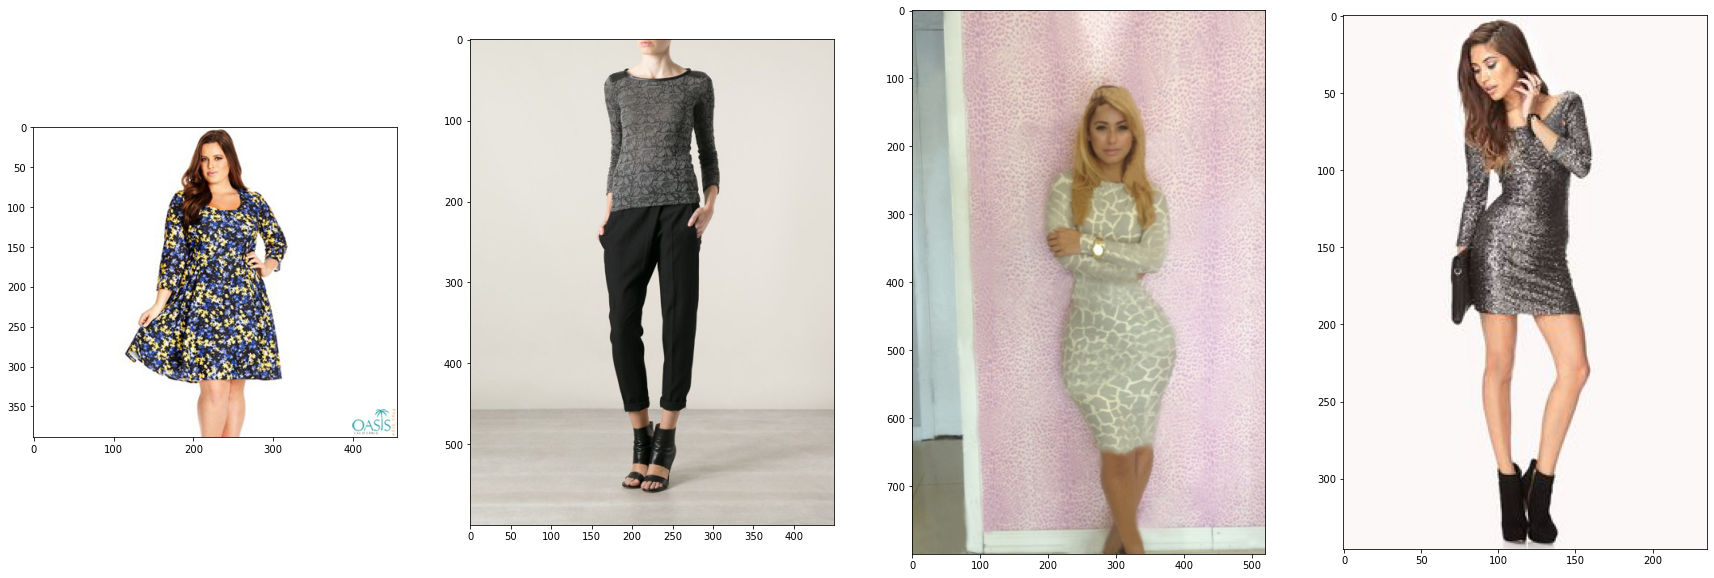

In [460]:
fig, axs = plt.subplots(1,4,figsize=(30,10))
for i in range(4):
    img_name_test = data_full[data_full[attr]==1].sample(1).iloc[0,0]
    path = 'data/DeepFashion_categorical_images_high/'
    full_path = path+img_name_test
    img = Image.open(full_path)
    axs[i].imshow(img)

# DeepFashion section classifier

In [462]:
section = pd.read_csv('data/DeepFashion_section - train/fabric.txt',sep=' ',names = ['img','upper','lower','outer'],header=None,index_col=False)



In [463]:
section['back'] = np.where(section['img'].str.contains('_back'),1,0)

In [464]:
section['full body'] = np.where(section['img'].str.contains('WOMEN-Dresses|WOMEN-Rompers'),1,0)
                              

In [466]:
section['outfit'] = np.where((((section['upper']!=7) |(section['lower']!=7)) & ((section['upper']!=7) |(section['outer']!=7))) & (section['full body']==0) & (section['back']==0),1,0)



In [467]:
section

img  upper  lower outer  \
0             MEN-Denim-id_00000080-01_7_additional.jpg      1      1     7   
1             MEN-Denim-id_00000089-01_7_additional.jpg      1      1     7   
2             MEN-Denim-id_00000089-02_7_additional.jpg      1      1     7   
3             MEN-Denim-id_00000089-03_7_additional.jpg      1      1     7   
4             MEN-Denim-id_00000089-04_7_additional.jpg      0      1     7   
...                                                 ...    ...    ...   ...   
44091        WOMEN-Tees_Tanks-id_00007979-04_4_full.jpg      1      1     7   
44092  WOMEN-Tees_Tanks-id_00007979-04_7_additional.jpg      1      0     7   
44093       WOMEN-Tees_Tanks-id_00007981-03_1_front.jpg      1      0     7   
44094        WOMEN-Tees_Tanks-id_00007981-03_3_back.jpg      1      0     7   
44095  WOMEN-Tees_Tanks-id_00007981-03_7_additional.jpg      1      0     7   

       back  full body  outfit  
0         0          0       1  
1         0          0       1  
2         0          0       1  
3         0          0       1  
4         0          0       1  
...     ...        ...     ...  
44091     0          0       1  
44092     0          0       1  
44093     0          0       1  
44094     1          0       0  
44095     0          0       1  

[44096 rows x 7 columns]

In [468]:
section = section.drop(columns=['outer','lower','upper'])

In [470]:
landmarks_section = pd.read_csv('data/DeepFashion_section - train/keypoints_loc.txt',sep=' ',usecols=[0,15,16,17,18,29,30,31,32,39,40,41,42],names=['img','x1','y1','x2','y2','x3','y3','x4','y4','x5','y5','x6','y6'], header=None,index_col=False)


In [471]:
data_full_section = section.merge(landmarks_section, on='img',how='left')

In [472]:
data_full_section = data_full_section.dropna()

In [473]:
data_full_section[data_full_section['outfit']==1]

img  back  full body  \
0             MEN-Denim-id_00000080-01_7_additional.jpg     0          0   
1             MEN-Denim-id_00000089-01_7_additional.jpg     0          0   
2             MEN-Denim-id_00000089-02_7_additional.jpg     0          0   
3             MEN-Denim-id_00000089-03_7_additional.jpg     0          0   
4             MEN-Denim-id_00000089-04_7_additional.jpg     0          0   
...                                                 ...   ...        ...   
44074  WOMEN-Tees_Tanks-id_00007969-04_7_additional.jpg     0          0   
44078  WOMEN-Tees_Tanks-id_00007970-01_7_additional.jpg     0          0   
44082        WOMEN-Tees_Tanks-id_00007976-01_4_full.jpg     0          0   
44086        WOMEN-Tees_Tanks-id_00007979-03_4_full.jpg     0          0   
44091        WOMEN-Tees_Tanks-id_00007979-04_4_full.jpg     0          0   

       outfit     x1     y1     x2     y2     x3     y3     x4     y4     x5  \
0           1  267.0  234.0  509.0  229.0  291.0  521.0  478.0  530.0  324.0   
1           1  347.0  201.0  598.0  194.0  388.0  519.0  588.0  520.0  492.0   
2           1  236.0  234.0  491.0  241.0  266.0  543.0  462.0  534.0  330.0   
3           1  225.0  237.0  467.0  211.0  268.0  540.0  470.0  531.0  377.0   
4           1  244.0  235.0  480.0  228.0  269.0  545.0  465.0  541.0  341.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
44074       1  221.0  218.0  392.0  180.0  225.0  503.0  416.0  491.0  329.0   
44078       1  242.0  229.0  446.0  200.0  245.0  444.0  433.0  460.0  292.0   
44082       1  288.0  225.0  473.0  193.0  297.0  474.0  475.0  486.0  410.0   
44086       1  287.0  210.0  466.0  172.0  274.0  467.0  462.0  474.0  359.0   
44091       1  275.0  187.0  468.0  207.0  282.0  485.0  468.0  475.0  335.0   

           y5     x6      y6  
0      1028.0  358.0  1029.0  
1      1036.0  511.0  1024.0  
2      1037.0  400.0  1034.0  
3      1040.0  394.0  1024.0  
4      1041.0  399.0  1041.0  
...       ...    ...     ...  
44074   999.0  327.0   910.0  
44078  1010.0  345.0   921.0  
44082  1022.0  502.0  1026.0  
44086  1023.0  361.0  1038.0  
44091  1009.0  346.0  1035.0  

[9265 rows x 16 columns]

In [474]:
data_full_section = data_full_section[(data_full_section['outfit']==1) | (data_full_section['full body']==1) | (data_full_section['back']==1)]


In [475]:
data_full_section

img  back  full body  \
0             MEN-Denim-id_00000080-01_7_additional.jpg     0          0   
1             MEN-Denim-id_00000089-01_7_additional.jpg     0          0   
2             MEN-Denim-id_00000089-02_7_additional.jpg     0          0   
3             MEN-Denim-id_00000089-03_7_additional.jpg     0          0   
4             MEN-Denim-id_00000089-04_7_additional.jpg     0          0   
...                                                 ...   ...        ...   
44074  WOMEN-Tees_Tanks-id_00007969-04_7_additional.jpg     0          0   
44078  WOMEN-Tees_Tanks-id_00007970-01_7_additional.jpg     0          0   
44082        WOMEN-Tees_Tanks-id_00007976-01_4_full.jpg     0          0   
44086        WOMEN-Tees_Tanks-id_00007979-03_4_full.jpg     0          0   
44091        WOMEN-Tees_Tanks-id_00007979-04_4_full.jpg     0          0   

       outfit     x1     y1     x2     y2     x3     y3     x4     y4     x5  \
0           1  267.0  234.0  509.0  229.0  291.0  521.0  478.0  530.0  324.0   
1           1  347.0  201.0  598.0  194.0  388.0  519.0  588.0  520.0  492.0   
2           1  236.0  234.0  491.0  241.0  266.0  543.0  462.0  534.0  330.0   
3           1  225.0  237.0  467.0  211.0  268.0  540.0  470.0  531.0  377.0   
4           1  244.0  235.0  480.0  228.0  269.0  545.0  465.0  541.0  341.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
44074       1  221.0  218.0  392.0  180.0  225.0  503.0  416.0  491.0  329.0   
44078       1  242.0  229.0  446.0  200.0  245.0  444.0  433.0  460.0  292.0   
44082       1  288.0  225.0  473.0  193.0  297.0  474.0  475.0  486.0  410.0   
44086       1  287.0  210.0  466.0  172.0  274.0  467.0  462.0  474.0  359.0   
44091       1  275.0  187.0  468.0  207.0  282.0  485.0  468.0  475.0  335.0   

           y5     x6      y6  
0      1028.0  358.0  1029.0  
1      1036.0  511.0  1024.0  
2      1037.0  400.0  1034.0  
3      1040.0  394.0  1024.0  
4      1041.0  399.0  1041.0  
...       ...    ...     ...  
44074   999.0  327.0   910.0  
44078  1010.0  345.0   921.0  
44082  1022.0  502.0  1026.0  
44086  1023.0  361.0  1038.0  
44091  1009.0  346.0  1035.0  

[12692 rows x 16 columns]

In [476]:
outfit_only = data_full_section[(data_full_section['outfit']==1) & (data_full_section['full body']==0) & (data_full_section['back']==0)].value_counts().sum()
outfit_only


9265

In [477]:
lower_only = upper_only = outfit_only

In [478]:
back_only = data_full_section[(data_full_section['outfit']==0) & (data_full_section['full body']==0) & (data_full_section['back']==1)].value_counts().sum()
back_only


174

In [479]:
full_body_only = data_full_section[(data_full_section['outfit']==0) & (data_full_section['full body']==1) & (data_full_section['back']==0)].value_counts().sum()
full_body_only



2939

In [480]:
total_images = outfit_only + upper_only + lower_only + full_body_only + back_only
total_images

30908

In [481]:
def partition_image(s):
    path = 'data/DeepFashion_multimodal_images/'
    img_name = s[0]
    full_path = path+img_name
    image = cv2.imread(full_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    x = s[4::2].astype(int)
    y = s[5::2].astype(int)

    upper = image[-50+y[0]:y[2], -100+min(x[0],x[1]):max(x[0],x[1])+100]
    lower = image[-50+y[2]:y[4], -100+min(x[2],x[3]):max(x[2],x[3])+100]
    return image, upper, lower

In [482]:
def display_outfit(s):
    image, upper, lower = partition_image(s)        
    fig,axs = plt.subplots(1,3,figsize=(30,20))
    axs[0].imshow(image)
    axs[0].set_title('Original image')
    axs[1].imshow(upper)
    axs[1].set_title('Upper')
    axs[2].imshow(lower)
    axs[2].set_title('Lower')
    return

In [483]:
def display_upper(s):
    image, upper, lower = partition_image(s)
    plt.imshow(upper)
    plt.title('Upper')
    return

In [484]:
def display_lower(s):
    image, upper, lower = partition_image(s)
    plt.imshow(lower)
    plt.title('Lower')
    return

In [485]:
def display_image(s):
    path = 'data/DeepFashion_multimodal_images/'
    img_name = s[0]
    full_path = path+img_name
    image = cv2.imread(full_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    return

In [486]:
def get_section(category):
    s = data_full_section[data_full_section['outfit']==1].sample(n=1).values[0]
    plt.figure(figsize=(30,10))
    if category =='outfit':
        display_outfit(s)
    if category == 'lower':
        display_lower(s)
    if category == 'upper':
        display_upper(s) 
    if category == 'full body' or category == 'back':
        s = data_full_section[data_full_section[category]==1].sample(n=1).values[0]
        display_image(s)
    

# Presentation

In [487]:
data_full_section

img  back  full body  \
0             MEN-Denim-id_00000080-01_7_additional.jpg     0          0   
1             MEN-Denim-id_00000089-01_7_additional.jpg     0          0   
2             MEN-Denim-id_00000089-02_7_additional.jpg     0          0   
3             MEN-Denim-id_00000089-03_7_additional.jpg     0          0   
4             MEN-Denim-id_00000089-04_7_additional.jpg     0          0   
...                                                 ...   ...        ...   
44074  WOMEN-Tees_Tanks-id_00007969-04_7_additional.jpg     0          0   
44078  WOMEN-Tees_Tanks-id_00007970-01_7_additional.jpg     0          0   
44082        WOMEN-Tees_Tanks-id_00007976-01_4_full.jpg     0          0   
44086        WOMEN-Tees_Tanks-id_00007979-03_4_full.jpg     0          0   
44091        WOMEN-Tees_Tanks-id_00007979-04_4_full.jpg     0          0   

       outfit     x1     y1     x2     y2     x3     y3     x4     y4     x5  \
0           1  267.0  234.0  509.0  229.0  291.0  521.0  478.0  530.0  324.0   
1           1  347.0  201.0  598.0  194.0  388.0  519.0  588.0  520.0  492.0   
2           1  236.0  234.0  491.0  241.0  266.0  543.0  462.0  534.0  330.0   
3           1  225.0  237.0  467.0  211.0  268.0  540.0  470.0  531.0  377.0   
4           1  244.0  235.0  480.0  228.0  269.0  545.0  465.0  541.0  341.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
44074       1  221.0  218.0  392.0  180.0  225.0  503.0  416.0  491.0  329.0   
44078       1  242.0  229.0  446.0  200.0  245.0  444.0  433.0  460.0  292.0   
44082       1  288.0  225.0  473.0  193.0  297.0  474.0  475.0  486.0  410.0   
44086       1  287.0  210.0  466.0  172.0  274.0  467.0  462.0  474.0  359.0   
44091       1  275.0  187.0  468.0  207.0  282.0  485.0  468.0  475.0  335.0   

           y5     x6      y6  
0      1028.0  358.0  1029.0  
1      1036.0  511.0  1024.0  
2      1037.0  400.0  1034.0  
3      1040.0  394.0  1024.0  
4      1041.0  399.0  1041.0  
...       ...    ...     ...  
44074   999.0  327.0   910.0  
44078  1010.0  345.0   921.0  
44082  1022.0  502.0  1026.0  
44086  1023.0  361.0  1038.0  
44091  1009.0  346.0  1035.0  

[12692 rows x 16 columns]

In [488]:
@interact
def category_classifier(category=['lower','upper','outfit','full body', 'back']):
    get_section(category)

interactive(children=(Dropdown(description='category', options=('lower', 'upper', 'outfit', 'full body', 'back…

In [489]:
data_full['category'].unique()

array(['Blouse', 'Blazer', 'Button-Down', 'Bomber', 'Anorak', 'Tee',
       'Tank', 'Top', 'Sweater', 'Flannel', 'Hoodie', 'Cardigan',
       'Jacket', 'Henley', 'Poncho', 'Jersey', 'Turtleneck', 'Parka',
       'Peacoat', 'Halter', 'Skirt', 'Shorts', 'Jeans', 'Joggers',
       'Sweatpants', 'Jeggings', 'Cutoffs', 'Sweatshorts', 'Leggings',
       'Culottes', 'Chinos', 'Trunks', 'Sarong', 'Gauchos', 'Jodhpurs',
       'Capris', 'Dress', 'Romper', 'Coat', 'Kimono', 'Jumpsuit', 'Robe',
       'Caftan', 'Kaftan', 'Coverup', 'Onesie'], dtype=object)

In [490]:
data_full[data_full['category']=='Flannel'].head(10)

img     scale category category_type  \
33575  Boxy_Plaid_Flannel/img_00000001.jpg  1.502439  Flannel         upper   
33576  Boxy_Plaid_Flannel/img_00000002.jpg  6.000000  Flannel         upper   
33577  Boxy_Plaid_Flannel/img_00000003.jpg  1.327434  Flannel         upper   
33578  Boxy_Plaid_Flannel/img_00000004.jpg  2.000000  Flannel         upper   
33579  Boxy_Plaid_Flannel/img_00000005.jpg  1.000000  Flannel         upper   
33580  Boxy_Plaid_Flannel/img_00000006.jpg  1.593750  Flannel         upper   
33581  Boxy_Plaid_Flannel/img_00000007.jpg  2.500000  Flannel         upper   
33582  Boxy_Plaid_Flannel/img_00000008.jpg  2.708333  Flannel         upper   
33583  Boxy_Plaid_Flannel/img_00000009.jpg  1.502439  Flannel         upper   
33584  Boxy_Plaid_Flannel/img_00000010.jpg  3.660000  Flannel         upper   

       a-line  abstract  abstract_chevron  abstract_chevron_print  \
33575      -1        -1                -1                      -1   
33576      -1        -1                -1                      -1   
33577      -1        -1                -1                      -1   
33578      -1        -1                -1                      -1   
33579      -1        -1                -1                      -1   
33580      -1        -1                -1                      -1   
33581      -1        -1                -1                      -1   
33582      -1        -1                -1                      -1   
33583      -1        -1                -1                      -1   
33584      -1        -1                -1                      -1   

       abstract_diamond  abstract_floral  abstract_floral_print  abstract_geo  \
33575                -1               -1                     -1            -1   
33576                -1               -1                     -1            -1   
33577                -1               -1                     -1            -1   
33578                -1               -1                     -1            -1   
33579                -1               -1                     -1            -1   
33580                -1               -1                     -1            -1   
33581                -1               -1                     -1            -1   
33582                -1               -1                     -1            -1   
33583                -1               -1                     -1            -1   
33584                -1               -1                     -1            -1   

       abstract_geo_print  abstract_paisley  abstract_pattern  abstract_print  \
33575                  -1                -1                -1              -1   
33576                  -1                -1                -1              -1   
33577                  -1                -1                -1              -1   
33578                  -1                -1                -1              -1   
33579                  -1                -1                -1              -1   
33580                  -1                -1                -1              -1   
33581                  -1                -1                -1              -1   
33582                  -1                -1                -1              -1   
33583                  -1                -1                -1              -1   
33584                  -1                -1                -1              -1   

       abstract_printed  abstract_stripe  acid  acid_wash  americana  angeles  \
33575                -1               -1    -1         -1         -1       -1   
33576                -1               -1    -1         -1         -1       -1   
33577                -1               -1    -1         -1         -1       -1   
33578                -1               -1    -1         -1         -1       -1   
33579                -1               -1    -1         -1         -1       -1   
33580                -1               -1    -1         -1         -1       -1   
33581                -1               -1    -1         -1 

In [491]:
@interact
def garment_classifier(index = [33578, 209173, 144941, 246922 ,273838, 200076, 70309]):
    display_img_details(index)

interactive(children=(Dropdown(description='index', options=(33578, 209173, 144941, 246922, 273838, 200076, 70…

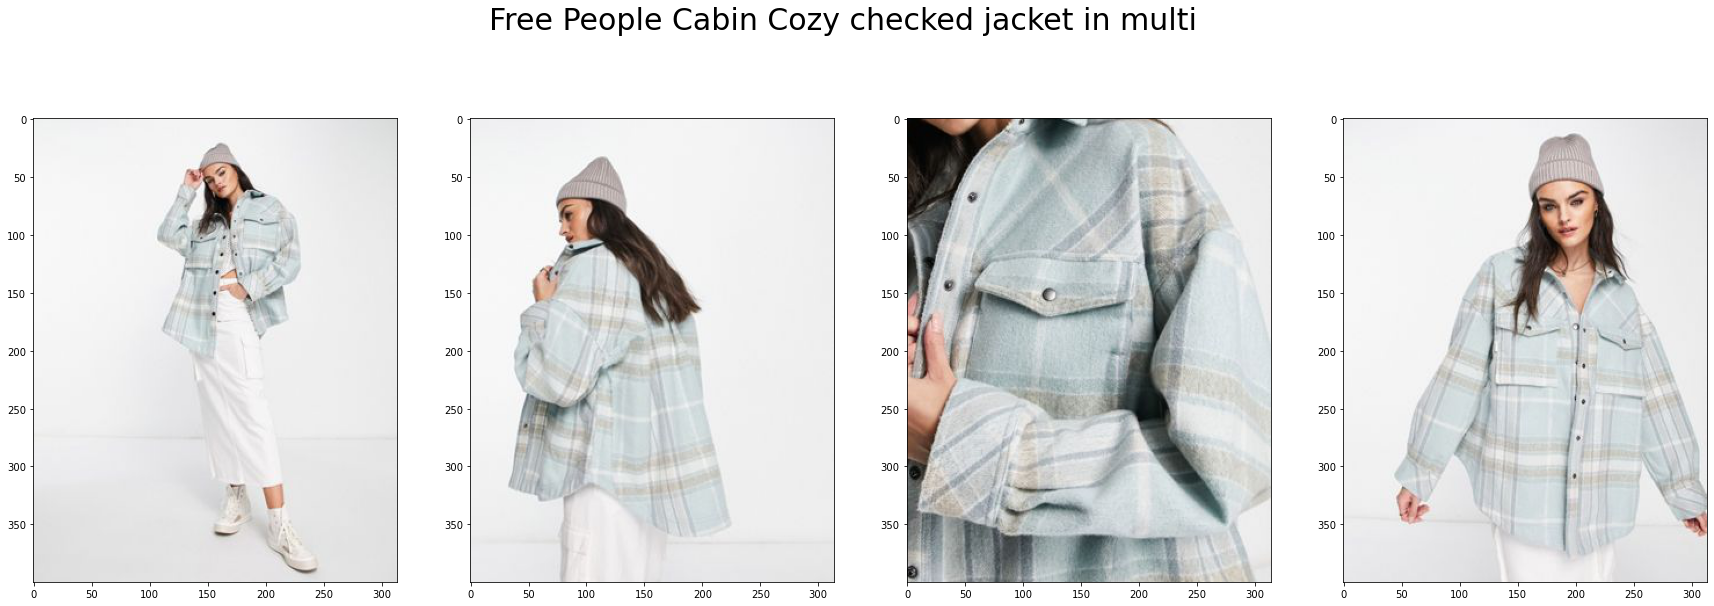

In [492]:
API = {'id': 202571726, 'name': 'Free People Cabin Cozy checked jacket in multi', 'price_current': 142.0, 'price_previous': None, 'marked_down': False, 'outlet': True, 'selling_fast': False, 'brand': 'Free People', 'url': 'https://www.asos.com/us/free-people/free-people-cabin-cozy-checked-jacket-in-multi/prd/202571726?clr=green-combo&colourWayId=202571731', 'url_image': ['images.asos-media.com/products/free-people-cabin-cozy-checked-jacket-in-multi/202571726-1-greencombo', 'images.asos-media.com/products/free-people-cabin-cozy-checked-jacket-in-multi/202571726-2', 'images.asos-media.com/products/free-people-cabin-cozy-checked-jacket-in-multi/202571726-3', 'images.asos-media.com/products/free-people-cabin-cozy-checked-jacket-in-multi/202571726-4']}
API_title = API['name']

fig, axs = plt.subplots(1,4,figsize=(30,10))
fig.suptitle(API_title,fontsize=30)
for i in range(4):
    API_image = 'http://'+API['url_image'][i]
    response = requests.get(API_image)
    img = Image.open(BytesIO(response.content))
    axs[i].imshow(img)

